In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# import & pip install

In [ ]:
!pip install trl
!pip install bitsandbytes
!pip install transformers

!pip install datasets
!pip install --upgrade datasets

!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.9/310.9 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 6.1 MB/s eta 0:00:00


In [ ]:


import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nlpaug
from nlpaug.augmenter.word import SynonymAug, ContextualWordEmbsAug

import pandas as pd
from datasets import Dataset
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, log_loss

from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    DistilBertForSequenceClassification,
    DistilBertTokenizer,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)

from torch.utils.data import Dataset
import torch
import numpy as np

from peft import PeftModel, PeftConfig, LoraConfig, get_peft_model, TaskType
from trl import SFTTrainer

from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix
import pandas as pd
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

from transformers import MarianMTModel, MarianTokenizer

from sklearn.model_selection import train_test_split
from transformers import get_scheduler

from transformers import EarlyStoppingCallback


nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# setting

In [ ]:
DATA_PATH='/content/drive/MyDrive/data_new/downsampled_new_data.csv'

TESTING_DATA_PATH= '/content/drive/MyDrive/data_new/data(4).csv'
BASE_MODEL_NAME = 'FacebookAI/roberta-base'
#BASE_MODEL_NAME = 'distilbert/distilbert-base-uncased-finetuned-sst-2-english'
#BASE_MODEL_NAME = 'bert-base-uncased'
#BASE_MODEL_NAME = 'mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis'
#BASE_MODEL_NAME = 'ProsusAI/finbert'
#BASE_MODEL_NAME = 'M-FAC/bert-tiny-finetuned-sst2'
#BASE_MODEL_NAME = 'cross-encoder/ms-marco-TinyBERT-L-2-v2'
#BASE_MODEL_NAME = 'philschmid/tiny-bert-sst2-distilled'
#BASE_MODEL_NAME = 'google/bert_uncased_L-2_H-128_A-2'
#BASE_MODEL_NAME = 'huawei-noah/TinyBERT_General_4L_312D'
#BASE_MODEL_NAME = 'google/electra-small-discriminator'
#BASE_MODEL_NAME = 'distilbert/distilbert-base-uncased'
#BASE_MODEL_NAME = 'google/bert_uncased_L-8_H-512_A-8'

CUSTOM_MODEL_PATH = '/content/drive/MyDrive/model/saved-model-path'

USE_LORA = False
USE_DATA_AUGMENTATION = False
USE_BACK_TRANSLATION = False
EPOCH = 7
BATCH_SIZE = 128

# data cleaning

In [ ]:
def data_cleaning(text_column):
  lemmatizer = WordNetLemmatizer()
  stop_words = set(stopwords.words('english'))

  def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

  if isinstance(text_column, list):
    return [clean_text(text) for text in text_column]

  elif isinstance(text_column, str):
    return clean_text(text_column)

  else:
    return ValueError("the form of text_column should be list or str")



# data augmentation

In [ ]:
def data_augmenting(sentences, sentiments, augmentation_factor=1):
    aug = SynonymAug(aug_src='wordnet', aug_max=3) #  同義詞
    cont_aug = ContextualWordEmbsAug(aug_max=3) # 可理解上下文(有點慢)
    augmented_sentences, augmented_sentiments = [], []

    for i, sentence in enumerate(sentences):
        for _ in range(augmentation_factor):

            augmented_sentences.append(str(aug.augment(sentence)))
            augmented_sentiments.append(sentiments[i])

            #augmented_sentences.append(str(cont_aug.augment(sentence)))
            #augmented_sentiments.append(sentiments[i])

    return sentences + augmented_sentences, sentiments + augmented_sentiments



# data augmentation (back translation)

In [ ]:

def back_translation_augment(sentences, sentiments, src_lang="en", tgt_lang="fr", augmentation_factor=1):

    augmented_sentences = []
    augmented_sentiments = []

    src_model_name = f'Helsinki-NLP/opus-mt-{src_lang}-{tgt_lang}'
    tgt_model_name = f'Helsinki-NLP/opus-mt-{tgt_lang}-{src_lang}'

    src_tokenizer = MarianTokenizer.from_pretrained(src_model_name)
    src_model = MarianMTModel.from_pretrained(src_model_name)
    tgt_tokenizer = MarianTokenizer.from_pretrained(tgt_model_name)
    tgt_model = MarianMTModel.from_pretrained(tgt_model_name)

    for i, sentence in enumerate(sentences):

        for _ in range(augmentation_factor):

            encoded = src_tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)
            tgt_output = src_model.generate(**encoded)
            tgt_sentence = src_tokenizer.decode(tgt_output[0], skip_special_tokens=True)


            encoded = tgt_tokenizer(tgt_sentence, return_tensors="pt", truncation=True, padding=True)
            back_translated_output = tgt_model.generate(**encoded)
            back_translated_sentence = tgt_tokenizer.decode(back_translated_output[0], skip_special_tokens=True)

            augmented_sentences.append(back_translated_sentence)
            augmented_sentiments.append(sentiments[i])

    return sentences + augmented_sentences, sentiments + augmented_sentiments


In [ ]:
def print_trainable_parameters(model):
    trainable_params = 0
    total_params = 0
    for param in model.parameters():
        total_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"Trainable parameters: {trainable_params}")
    print(f"Total parameters: {total_params}")
    print(f"Percentage of trainable parameters: {100 * trainable_params / total_params:.2f}%")


# SentimentAnalyzer

In [ ]:
from transformers import AutoConfig

class SentimentAnalyzer:
  def __init__(self, base_model_name, custom_model_path):
    self.base_model_name = base_model_name
    self.custom_model_path = custom_model_path



  def train(self, train_dataset, test_dataset):
    tokenizer = RobertaTokenizer.from_pretrained(self.base_model_name)
    model = RobertaForSequenceClassification.from_pretrained(self.base_model_name, num_labels=3, ignore_mismatched_sizes=True)


    # 預處理
    def preprocess_data(examples):
      return tokenizer(
          examples["text"], truncation=True, padding="max_length", max_length=128

      )
    train_dataset = train_dataset.map(preprocess_data, batched=True)
    test_dataset = test_dataset.map(preprocess_data, batched=True)

    train_dataset = train_dataset.remove_columns(["text"])
    test_dataset = test_dataset.remove_columns(["text"])

    train_dataset.set_format("torch")
    test_dataset.set_format("torch")

    # 訓練參數設置
    ''' lora_config = LoraConfig(
      lora_alpha=32,
      #lora_dropout=0.1,
      lora_dropout=0.3,
      r=16,
      bias="none",
      target_modules="all-linear",
      #target_modules=["q_lin", "k_lin","v_lin"],
      task_type=TaskType.SEQ_CLS,
    ) '''
    lora_config = LoraConfig(
          lora_alpha=128,
          lora_dropout=0.1,
          r=64,
          bias="none",
          target_modules="all-linear",
          task_type=TaskType.SEQ_CLS,
        )



    ''' training_args = TrainingArguments(
      output_dir='./results',  # 訓練結果保存的目錄
      evaluation_strategy="epoch",  # 每個 epoch 進行一次評估
      save_strategy="epoch",  # 每個 epoch 保存一次模型
      learning_rate=2e-5,
      per_device_train_batch_size=BATCH_SIZE,
      per_device_eval_batch_size=BATCH_SIZE,
      num_train_epochs=EPOCH,  # 訓練的 epoch 次數
      weight_decay=0.01,  # L2 正則化
      load_best_model_at_end=True,  # 在訓練結束時載入最好的模型
      metric_for_best_model="f1",  # 使用 F1-score 評估最好的模型
      save_total_limit=2,  # 最多保存的模型數量
      logging_dir='./logs',  # log保存的目錄
      logging_steps=10,  # 每 10 步紀錄一次log
      optim="adamw_hf",
      lr_scheduler_type = "cosine"
    ) '''
    training_args = TrainingArguments(
            output_dir='./model',          # output path
            logging_dir='./logs',            # log path
            logging_steps=10,
            evaluation_strategy="epoch",     # evaluate every epoch
            learning_rate=2e-5,              # learning rate
            per_device_train_batch_size=BATCH_SIZE,
            per_device_eval_batch_size=BATCH_SIZE,
            num_train_epochs=EPOCH,             # number of epoches
            weight_decay=0.05,
            optim="paged_adamw_32bit",
            #optim="adamw_hf",

            metric_for_best_model = 'f1',
            #lr_scheduler_type="reduce_lr_on_plateau",
            load_best_model_at_end = True,
            save_total_limit=1,  # 最多保存的模型數量
            save_strategy="epoch",  # 每個 epoch 保存一次模型
            lr_scheduler_type="cosine"


        )






    # 自定義評估指標
    def compute_metrics(pred):
      labels = pred.label_ids
      preds = pred.predictions.argmax(-1)
      return {
          "accuracy": accuracy_score(labels, preds),
          "precision": precision_score(labels, preds, average="weighted"),
          "recall": recall_score(labels, preds, average="weighted"),
          "f1": f1_score(labels, preds, average="weighted"),
      }

    # add LoRA adaptor
    if (USE_LORA):
      model = get_peft_model(model, lora_config)

    # 微調模型
    trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=train_dataset,
      eval_dataset=test_dataset,
      compute_metrics=compute_metrics,
      callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]

      #callbacks=[early_stopping],
    )

    #print_trainable_parameters(model)

    trainer.train()

    # 儲存模型
    trainer.save_model(CUSTOM_MODEL_PATH)
    tokenizer.save_pretrained(CUSTOM_MODEL_PATH)


# % of each sentiment of input data (DATA_PATH)

In [ ]:
def plot_sentiment_distribution(sentiments, colors=None, title='Sentiment Distribution'):

    # 統計每個情緒類別的數量
    sentiment_counts = pd.Series(sentiments).value_counts()

    # 繪製長條圖
    plt.figure(figsize=(8, 6))
    sentiment_counts.plot(kind='bar', color=colors)
    plt.title(title)
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.xticks(rotation=0)  # 讓 x 軸標籤不旋轉
    plt.show()

# main

In [ ]:
from datasets import Dataset
def main():
  # 讀取數據
  data_path = DATA_PATH
  df = pd.read_csv(data_path)

  # 檢查並清理資料

  # 1. 移除缺失值
  df = df.dropna(subset=["Sentence", "Sentiment"])

  # 2. 重命名欄位
  df = df.rename(columns={"Sentence": "text", "Sentiment": "label"})

  # 3. 標籤映射
  df["label"] = df["label"].map({"positive": 2, "neutral": 1, "negative": 0})

  # 4. 清理文字數據
  df["text"] = df["text"].apply(data_cleaning)

  # 5. 資料增強
  if (USE_DATA_AUGMENTATION):
    augmented_texts, augmented_labels = data_augmenting(df["text"].tolist(), df["label"].tolist(), augmentation_factor=1)
    df = pd.DataFrame({"text": augmented_texts, "label": augmented_labels})
  else:
    df = pd.DataFrame({"text": df["text"], "label": df["label"]})

  # 6. back translation
  if (USE_BACK_TRANSLATION):
    augmented_texts, augmented_labels = back_translation_augment(df["text"].tolist(), df["label"].tolist(), src_lang="en", tgt_lang="fr", augmentation_factor=1)
    df = pd.DataFrame({"text": augmented_texts, "label": augmented_labels})
  else:
    df = pd.DataFrame({"text": df["text"], "label": df["label"]})


  # 轉換為Dataset格式
  dataset = Dataset.from_pandas(df)

  # 分割訓練和測試data
  train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"],
    df["label"],
    test_size=0.2,
    random_state=42,
    stratify=df["label"]  # 使用 stratify 進行分層
  )

  # 將拆分後的數據轉為 Hugging Face Dataset 格式
  train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
  test_dataset = Dataset.from_dict({"text": test_texts, "label": test_labels})

  #train_dataset = dataset["train"]
  #test_dataset = dataset["test"]

  print("start training...")
  Analyzer = SentimentAnalyzer(base_model_name=BASE_MODEL_NAME, custom_model_path=CUSTOM_MODEL_PATH)
  Analyzer.train(train_dataset, test_dataset)
  print("training completely! The trained model has been saved at "+CUSTOM_MODEL_PATH)


if __name__ == "__main__":
    main()

start training...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/9081 [00:00<?, ? examples/s]

Map:   0%|          | 0/2271 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.489400,0.429526,0.839278,0.847322,0.839278,0.840028
2,0.365600,0.366562,0.862616,0.865044,0.862616,0.862867
3,0.280100,0.353944,0.873184,0.874689,0.873184,0.873457
4,0.233900,0.366535,0.876266,0.876807,0.876266,0.876032
5,0.203800,0.366710,0.882431,0.882470,0.882431,0.882223
6,0.159600,0.369320,0.883311,0.883932,0.883311,0.883284
7,0.135600,0.370102,0.885513,0.886274,0.885513,0.885572


training completely! The trained model has been saved at /content/drive/MyDrive/model/model-12015-roberta-1


In [ ]:

class SentimentPredictor:

    # initialize, should give the path of model
    def __init__(self, model_dir):
        self.model = RobertaForSequenceClassification.from_pretrained(model_dir)
        self.tokenizer = AutoTokenizer.from_pretrained(model_dir)

    # give the text and return the prob. of all sentiments
    def predict(self, text):
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
        if 'token_type_ids' in inputs:
            del inputs['token_type_ids']
        with torch.no_grad():
            outputs = self.model(**inputs)
            probabilities = torch.softmax(outputs.logits, dim=-1).numpy()[0]
            predicted_label = ['negative', 'neutral', 'positive'][np.argmax(probabilities)]


        return predicted_label, probabilities

class SentimentPredictor_lora:

    def __init__(self, model_dir):
        self.base_model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL_NAME, num_labels=3)
        self.tokenizer = BertTokenizer.from_pretrained(BASE_MODEL_NAME)
        self.model = PeftModel.from_pretrained(self.base_model, model_dir)

    def predict(self, text):
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
        if 'token_type_ids' in inputs:
            del inputs['token_type_ids']
        with torch.no_grad():

            outputs = self.model(**inputs)

            probabilities = torch.softmax(outputs.logits, dim=-1).numpy()[0]
            predicted_label = ['negative', 'neutral', 'positive'][np.argmax(probabilities)]
        return predicted_label, probabilities


# test

num of input data:  1464


processing...: 100%|██████████| 1464/1464 [03:17<00:00,  8.23it/s]

f1-score
0.7460083721648811
accuracy
0.7472677595628415
recall
0.7472677595628415
cross entropy
0.8893435336534995
mutilabel-confusion-matrix


ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (2).

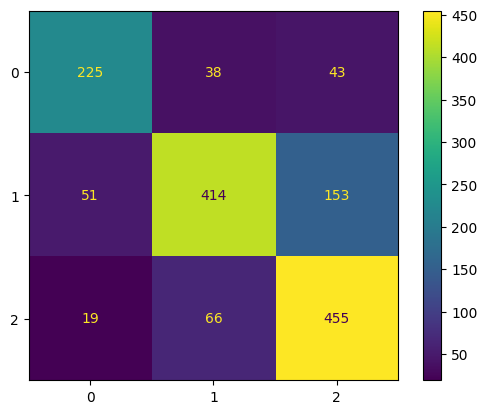

In [ ]:

if (USE_LORA == False):
  predictor = SentimentPredictor(model_dir=CUSTOM_MODEL_PATH)
else:
  predictor = SentimentPredictor_lora(model_dir=CUSTOM_MODEL_PATH)



data = pd.read_csv(TESTING_DATA_PATH)



texts = data.iloc[:, 0]
labels = data.iloc[:, 1]

print("num of input data: ", len(labels))
pbar = tqdm(total=len(labels), desc="processing...")


predictions = []
probs = []


for text in texts:
  prediction, prob = predictor.predict(text)

  # update the bar
  pbar.update(1)



  label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
  train_labels = label_map[prediction]
  predictions.append(train_labels)
  probs.append(prob)



label_map = {'negative': 0, 'neutral': 1, 'positive': 2}

labels = [label_map[sentiment] for sentiment in labels.tolist()]

print("f1-score")
print(f1_score(y_true=labels, y_pred=np.array(predictions), average="weighted"))

print("accuracy")
print(accuracy_score(labels, np.array(predictions)))

print("recall")
print(recall_score(labels, np.array(predictions), average="weighted"))

print("cross entropy")
print(log_loss(y_true=labels, y_pred=np.array(probs)))



print("mutilabel-confusion-matrix")
#print(multilabel_confusion_matrix(y_true=labels, y_pred=np.array(predictions)))
confusion_matrix = metrics.confusion_matrix(labels, np.array(predictions))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()